# Test Time Adaptation through Evolutionary Optimised Augmentation

 Giacomo Tomezzoli (241091) &  Davide Vandelli (240207)
 <br/>**Contact:** `{giacomo.tomezzoli, davide.vandelli} [at] studenti.unitn.it`
 <br/>**Github:** `https://github.com/gzemo...`

## Abstract

Abstract section

---

## Table of contents:
1. Introduction (here the link to the section)
2. Methods
3. Results
4. Discussion
5. Conclusion
6. References


---

## Introduction
Topic introduction, literature review motivation and novelty.


## Motivation
Ideas that let us formalised a new evolutionary based approach.

---

## Methods

### Augmentation search space
(describe the search space of each possibile augmentation and state what you would like to test in the present work: optimised cropping procedure)

### Search algorithm
(try to follow the scheme of some of previous studies on the topic)




And here we will go in detail about the technical requirements, and afterwards the general experimental methods we are using.

IMPORTANT: this notebook should never be used on jupyter notebook, but only on CoLAB, because some commands for preparation will change.

In [2]:
! pip install timm -q
! pip install cmaes -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.5 MB/s eta 0:00:00


In [3]:
%matplotlib inline

import os
import csv
import copy
import time
import timm
import itertools
import tarfile
import numpy as np
from PIL import Image
from cmaes import CMA
from io import BytesIO

import torch
import torchvision
import torchvision.transforms.v2 as v2
from torch.nn.modules.utils import _pair, _quadruple
from torch.distributions import Categorical
import torchvision.transforms.functional as ttf
from torch.utils.tensorboard import SummaryWriter # not used

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from google.colab import drive
from transformers import ResNetForImageClassification

from scipy.stats import entropy
from matplotlib import pyplot as plt

#import boto3 # aws s3
from pathlib import Path


# defining amount of Classes
NCLASSES = 1000

# defining DEVICE
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
resnet_model_name = "microsoft/resnet-50"
ViT_model_name    = "vit_base_patch16_224.augreg2_in21k_ft_in1k"
print(DEVICE)

cuda:0


### General set up
Mapping folder name and class number to Imagenet-1k true labels


In [4]:
LABELS, FOLDERS, COMMON = dict(), dict(), dict()

# preparing Imagenet-A_1k class number to label map
# {nclass : label_origin}
with open("imagenet1k_classes.txt") as f:
    for i,line in enumerate(f.readlines()):
        if i==0:
            continue
        items = line.strip().split("|")
        LABELS[int(items[1].strip())] = items[2].strip().lower()

# preparing testfolder class to name
# {foldername : label_folder}
with open("foldernames.txt") as f:
    for i,line in enumerate(f.readlines()):
        if line.startswith("n"):
            line = line.strip().split(" ")
            foldername = line[0]
            labelname  = " ".join(line[1:]).lower()
            FOLDERS[foldername] = labelname

# preparing folder labels to real Imagenet-A_1k labels map
# {label_origin : label_folder}
for k1 in FOLDERS.keys():
    query = FOLDERS[k1]
    for k2 in LABELS.keys():
        name, name_list = LABELS[k2], LABELS[k2].split(", ")
        for item in name_list:
            if query == item:
                COMMON[name] = query
                break
            break

### Backbone loading

In [5]:
# load and explain from where you gathered the models backbone: consider the idea
# to load also RVT* by giving enough explanations about the need to pre-load the model's
# weights through the official repository.

def backbone_loading(modelname):
    """
    Pretrained visual encoder backbone loading with state dictionary.
    Returns:
        model (torch.nn.Module)
        state (torch.nn.Module.state_dict) pretrained weights
    """
    if modelname == "resnet":
        model = ResNetForImageClassification.from_pretrained(resnet_model_name).to(DEVICE)
    elif modelname == "vit":
        model = timm.create_model(ViT_model_name, pretrained=True)
    elif modelname == "rvt":
        raise NotImplementedError
    else:
        raise Exception("Choose a valid backbone model (resnet, vit, rvt)")

    return model.to(DEVICE)

In [6]:
#test usage
model = backbone_loading("vit")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Here some function that will rename each test dataset subfolder name

In [7]:
# rename subfolders

### Reimplementing Memo approach
*Actually this part can be omitted: we can reimplement memo by using the final implementation and setting the evoOpt to false*

(single test data adaptation through prediction) decide whether to include also BN in a similar way (linear combination of $v_{train}$ and $v_{test}$ params).

Keep in mind that MEMO tested only over (should have tested over) an Imagenet partition: you need to reimplement that part, test with MEMO the other ImageNet partition and then hopefully improve with EvoAugmentation.

Introduce the amount of functions here presented.

In [8]:
# define here Entropy loss:
class EntropyLoss(torch.nn.Module):

    def __init__(self):
        super(EntropyLoss, self).__init__()

    def forward(self, probs):
        return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)))

In [9]:
def init_test_data_loader(image_data_folder, batch_size=1):
    """
    Test data dataLoader
    Args:
        image_data_folder: (str) path to folder  !!! check it out how it should work via Gdrive !!!
        batch_size: (int) amount of image to be put in the batch
    Return:
        torch.utils.data.DataLoader
    """
    # Resizing image and normalize according to ImageNet mean/std
    transformations = ttf.Compopse([
        ttf.Resize((256, 256)),   # !!! input model = (224, 224) keep it to 256 to crop it randomly !!!
        ttf.ToTensor(),
        ttf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #  !!! check it out if it makes sense !!!
        ])

    # preparing DataLoader
    test_dataset = torchvision.datasets.ImageFolder(
        root = image_data_folder,
        transform = transformations,
        )

    # !!! not sure if needed !!! #
    #_, test_data = torch.utils.data.random_split(test_dataset, [0, len(test_dataset)])
    return torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8)

def init_img_augmentation():
    """
    Description
    """
    return v2.Compose([
        v2.ToTensor(),
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        #v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # tensor normalization [-1, 1]
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # imageNet mean normalization
        # !!! go on with other augmentation implemented as in the original paper.
    ])

def entropyLoss(probs):
    """
    Description with latex formula
    """
    # !!! (check it out for squeeze, unsqueeze)
    return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)))

def init_optimizer():
    """
    Although you're just performing a single step parameter adaptation
    you'll need to have an optimizer
    """
    return torch.optim.Adam()

def batch_norm():
    """
    Description:
    """
    raise NotImplementedError

def single_test_time_adaptation(model, state, test_image, augmenter, optimizer,
                                nAugmented=16, trainIter=1):
    """
    Perform prediction via TTA given a single test_image.
    Args:
        model: (torch.nn.Module) visual encoder backbone
        state: (torch.nn.Module.state_dict) original model params
        test_image: (torch.tensor) single DataLoader instance
        augmenter: (torchvision.transforms.v2.Compose) transform block
        optimizer:
        nAugmented: (int) amount of on-the-fly augmentation
        trainIter: (int) amount of self-supervised training steps (default: 1)
    """
    # set model as trainable if TTA is allowed
    if trainIter > 0:
        model.train()
        batch = test_image.repeat(nAugmented, 1, 1, 1)
        batch.to(DEVICE)

        for epoch in range(0, trainIter):

            # augment test image
            # !!! check if test_image.shape == (1,C,H,W) or (C,H,W)
            augm_batch = augmenter(batch)

            # Forward pass
            outputs = model(augm_batch) # .squeeze(0)
            probs = torch.softmax(outputs, -1)

            # Loss computation
            loss = entropyLoss(probs)

            # Backward pass
            loss.backward()

            # Parameters update
            optimizer.step()

            # Gradients reset
            optimizer.zero_grad()

    # "Episodic" version (updating within each single test datapoint)
    model.eval()

    with torch.no_grad():
        outputs = model(test_image) # .squeeze(0)
        probs = torch.softmax(outputs, -1)
        loss = entropyLoss(probs)

    # reset current model params
    model.load_state_dict(state)

    return probs, loss


def test(data_folder, model, state, labels, trainIter=1):
    """
    Perform all evalutation steps for each test image in the current Test set
    via Test Time Adaptation as in MEMO
    Args:
        data_folder: (str) where to look to load test data
        model: (torch.nn.Module) visual encoder backbone
        state: (torch.nn.Module.state_dict) original model params
        labels: (array) true labels
        trainIter: (int) if > 0 TTA is enabled
    Return:
        accuracy over the current dataset
        computational time
    """
    samples, cum_loss, cum_accuracy = 0., 0., 0.

    data_loader = init_test_data_loader(data_folder)

    augmenter = init_img_augmentation()
    optimizer = init_optimizer()

    t0 = time.time()
    for idx, (test_image, curr_label) in enumerate(data_loader):

        #!!! progress bar !!!

        # forward pass with TTA
        probs, loss = single_test_time_adaptation(model, state, test_image, augmenter,
                                            optimizer, nAugmented=128, trainIter=trainIter)

        # extract predicted class
        pred_class = labels[torch.argmax(probs)]

        # accuracy
        cum_accuracy += pred_class.eq(curr_label).sum().item() # !! check it ##

        # Fetch prediction and loss value
        samples += test_image.shape[0]
        cum_loss += loss.item()
        _, predicted = outputs.max(1)

    t1 = time.time()
    return cum_accuracy/samples, round(t1-t0,3)

Testing combinations of backbones and image test sets + organize in a table!!! It would be useful to have also an ablation study that shows the difference in performance both in terms of accuracy and computational time required by varying models/trainIter.

In [10]:
def init_csv_results():
    with open("MEMOresults.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer = writerow(["dataset", "model_name", "train_iter", "accuracy", "execution_time" ])

def append_csv_results(data_folder, model_name, trainIter, accuracy, t):
    with open("MEMOresults.csv", "a", newline="") as csvfile:
        writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([data_folder, model_name, trainIter, accuracy, t])

#init_csv_results()

#labels = # load al possible true labels
#data_folder = #
#for model_name in ["resnet", "vit", "rvt"]: # decide either to take or remove
#    model, state = backbone_loading(model_name)
#    for trainIter in range(1, 3):
#        accuracy, t = test(data_folder, model, state, labels, trainIter=trainIter)
#        append_csv_results(data_folder, model_name, trainIter, accuracy, t)


# image modification function to be
# torchvision.transforms.functional.crop

In [11]:
#net = backbone_loading()
#for param_tensor in net.state_dict():
#    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

In [12]:
#help(net.load_state_dict)
#net.load_state_dict(net.state_dict())

### Testing Entropy Map

In this section the Entropyh map will be addressed by implementing a custom pooling layer that will be used in order to preprocess the test image to be further optimise the evolutionary process.

In [13]:
# efficiency entropy pooling map
class EntropyPool2d(torch.nn.Module):

    def __init__(self, kernel_size=3, stride=1, padding=0):
        super(EntropyPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)

    def _entropy(self, x):
        norm_x = x / x.sum()
        return Categorical(probs = norm_x).entropy()

    def forward(self, x):
        x = x.to(DEVICE)
        if len(x.shape) == 2:
            h,w = x.shape[0], x.shape[1]
        elif len(x.shape) == 3:
            h,w = x.shape[1], x.shape[2]
        x = x.reshape(1, 1, h,w)
        #print("0", x.shape)
        x = ttf.pad(x, tuple([(self.k[0]-1)//2]*4), padding_mode='edge')
        #print("1", x.shape)
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        #print("2", x.shape)
        x = x.contiguous().view(x.size()[:4] + (-1,))
        #print("3",x.shape
        pool = self._entropy(x).squeeze(0)
        #print("4",pool.shape)
        return pool.to("cpu")

# experimental: functional version
def e_pooling(img, kernel_size=3, stride=1, padding=0):
    """ Functional version of EntropyPool2d class """
    ep = EntropyPool2d(kernel_size, stride, padding).to(DEVICE)
    pool = ep(img)
    return pool.to("cpu")

# General purpose pooling function (with stride = 1 and same padding)
# allowing to perform any array-based function over unfolded sub-matrices
# CPU based pooling operator slower and robust version (can deal with certain
# image patterns (with blank padding))
def entropy_pooling(img, k=3, fun=entropy):
    """
    Perform same padding entropy pooling by convoluting a kernel of size k
    (and stride=1) over the imput image
    Args:
        img: (Pil.Image) image in grayscale
        k: (int) kernel size
        fun: function to apply (default: scipy.stats.entropy)
    Return torch.Tensor
    """
    assert k % 2 != 0, "Kernel size must be an even number."

    # tensor conversion (!!! remove it !!!)
    img = ttf.to_tensor(img) if not isinstance(img, torch.Tensor) else img
    h, w = img.shape[1:]

    # adding the channel dimension (bachsize, nchannel, H, W)
    img = img.reshape(1, 1, h, w)

    # padding by adding edge values all over the image boundaries
    img = ttf.pad(img, tuple([(k-1)//2]*4), padding_mode='edge')

    # unfolding
    folds = img.unfold(2,k,1).unfold(3,k,1).transpose(1,3).reshape(-1, 1, k, k)

    # Entropy pooling: applying the input function to each image sub-fold
    e_pooling = torch.tensor(list(map(fun, [folds[i, 0, :, :].flatten() for i in range(folds.shape[0])])))

    # folding back
    pooled = torch.reshape(e_pooling, (h,w)).transpose(-1,0).unsqueeze(0)

    return pooled

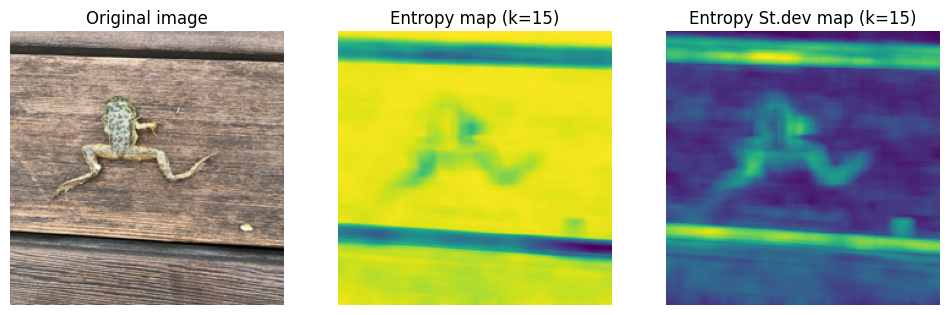

In [14]:
imagename = "frog.jpg"
orig = Image.open(imagename).convert("RGB").resize((224,224))
img  = ttf.to_tensor(orig.convert("L"))

k = 15

# pooling module
#ep = EntropyPool2d(kernel_size = k).to(DEVICE)
#emap = ep(img)

emap = e_pooling(img, k)

# std map
stdmap = entropy_pooling(img, k = k, fun = torch.std)

# plotting
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].imshow(orig)
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(emap[0,:,:])
axs[1].set_title(f"Entropy map (k={k})")
axs[1].axis("off")
axs[2].imshow(stdmap[0,:,:])
axs[2].set_title(f"Entropy St.dev map (k={k})")
axs[2].axis("off")
plt.show()

In [15]:
# precompute the entropy map for a grid of kernel sizes
tosave = dict()
ks = [3, 7, 11, 21, 31]
for k in ks:
    emap = e_pooling(img, k)
    s = entropy_pooling(img, k=k, fun=torch.std)
    tosave[k] = (emap,s)

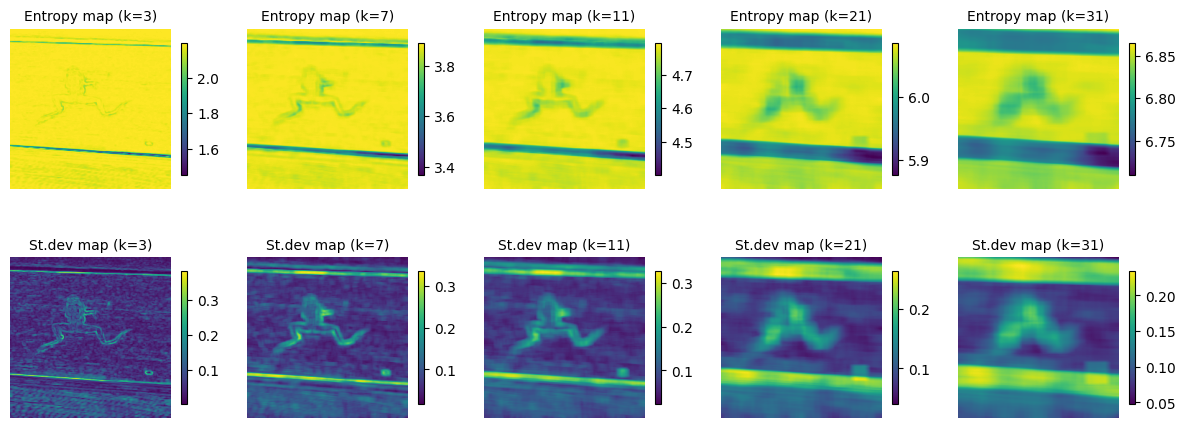

In [16]:
# plot
fig, axs = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axs.flatten()):
    if i < 5:
        mat = ax.imshow(tosave[ks[i]][0][0,:,:])
        ax.set_title(f"Entropy map (k={ks[i]})", fontsize=10)

    else:
        mat = ax.imshow(tosave[ks[i-5]][1][0,:,:])
        ax.set_title(f"St.dev map (k={ks[i-5]})", fontsize=10)

    ax.axis("off")
    cbar = fig.colorbar(mat, ax = ax, shrink=0.55)

plt.tight_layout()
plt.show()

This cell below as a backup in order to compute any pooling operation with a custom function implementing folding and unfolding of a given matrix.
It needs to be optimised since the pooling coputation is performed via python map before unfolding into the original matrix.

### Frequency filtering


Here the complete CMA-ES block evolving cropping regions is implemented

In [17]:
class FrequencyPass():
    def __init__(self, h:int, w:int, s:int, freq:str):
        self.h, self.w, self.s = h, w, s
        self.freq = freq

    def _freq_mask(self):
        # find conditions over the x axis
        xc = np.where(abs(np.arange(0, self.w)-(self.w/2)) <= self.s/2, 1, 0)\
            if self.freq=="low" \
            else np.where(abs(np.arange(0, self.w)-(self.w/2))\
                <= (min(self.h,self.w)-self.s)/2, 0, 1)
        # find conditions over the y axis
        yc = np.where(abs(np.arange(0, self.h)-(self.h/2)) <= self.s/2, 1, 0)\
            if self.freq=="low" \
            else np.where(abs(np.arange(0, self.h)-(self.h/2))\
                <= (min(self.h,self.w)-self.s)/2, 0, 1)
        return yc.reshape((yc.shape[0],1)).dot(xc.reshape((1,xc.shape[0])))

    def filter(self, img):
        return torch.tensor(abs(np.fft.ifft2(np.multiply(
            self._freq_mask(self.h, self.w, self.s, self.freq),
            np.fft.fftshift(np.fft.fft2(img))
        )))).unsqueeze(0)

# functional implementation
#def freq_filter(img, h,w,s,freq):
#    fp = FrequencyPass(h, w, s, freq)
#    return fp.filter(img)
### try the functional version (not sure it would be better, just more elegant)

def freq_mask(h,w,s, freq="low"):
    """
    Compute mask estimation according to either "low" or "high"
    frequency pass.
    Args:
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor binary mask
    """
    xc = np.where(abs(np.arange(0, w)-(w/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, w)-(w/2)) <= (min(h,w)-s)/2, 0, 1)
    yc = np.where(abs(np.arange(0, h)-(h/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, h)-(h/2)) <= (min(h,w)-s)/2, 0, 1)
    return yc.reshape((yc.shape[0],1)).dot(xc.reshape((1,xc.shape[0])))

def freq_filter(img, h,w,s, freq="low"):
    """
    Return the preprocessed frequency map image according to either
    "low" or "high" frequency pass.
    Args:
        img: (torch.tensor) input image
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor
    """
    return torch.tensor(abs(np.fft.ifft2(np.multiply(freq_mask(h,w,s,freq),
                                                    np.fft.fftshift(np.fft.fft2(img))
                                                    )))).unsqueeze(0)

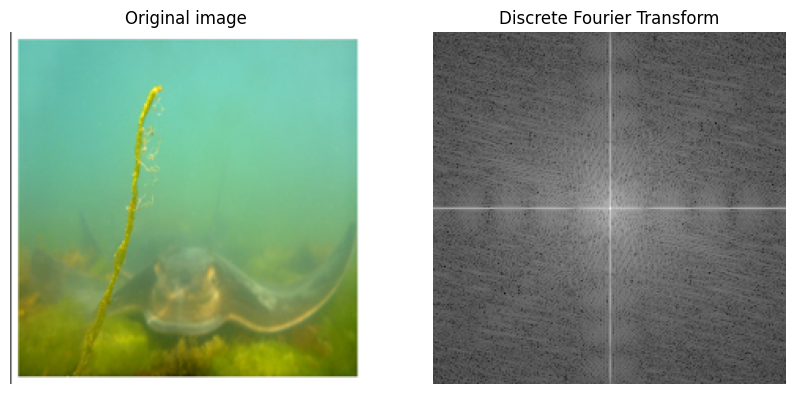

In [18]:
imgfilename = "imageneta.png"
h,w = (224,224)
orig = Image.open(imgfilename).convert("RGB").resize((h,w))
img  = Image.open(imgfilename).convert("L").resize((h,w))
ftransformed = np.fft.fftshift(np.fft.fft2(img))
inv_ftrasformed = np.fft.ifft2(ftransformed)

# plotting
fig, axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(orig)
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(np.log(abs(ftransformed)), cmap='gray')
axs[1].set_title("Discrete Fourier Transform")
axs[1].axis("off")
plt.show()

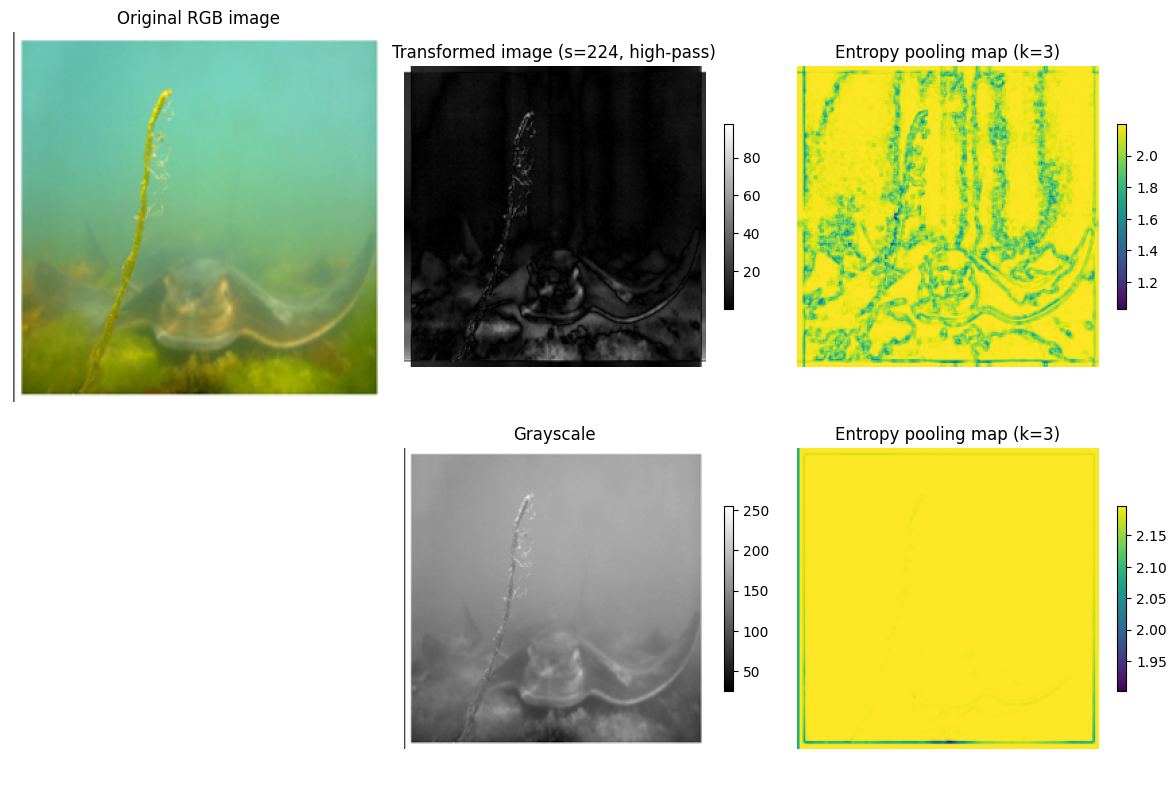

In [19]:
# Hyperparameters definition
factor = 1            # how much s needs to be reweighted (0=none,1=full)
s      = h * factor   # freq filter size
k      = 3           # entropy pooling kernel size
freq   = "high"       # "low" or "high" pass filtering

freq_filt_img = freq_filter(img, h, w, s, freq)
ep = EntropyPool2d(kernel_size=k).to(DEVICE)

entropy_img_frmap = ep(freq_filt_img)

try:
    entropy_img_map   = ep(ttf.to_tensor(img))
except:
    entropy_img_map   = entropy_pooling(ttf.to_tensor(img), k=k)

fig, axs = plt.subplots(2 , 3, figsize=(12,8))
axs[0][0].imshow(orig)
axs[0][0].set_title("Original RGB image", fontsize=12)
axs[0][0].axis("off")

m1 = axs[0][1].imshow(freq_filt_img[0,:,:], cmap="gray")
axs[0][1].set_title(f"Transformed image (s={round(s)}, {freq}-pass)", fontsize=12)
axs[0][1].axis("off")
cbar = fig.colorbar(m1, ax = axs[0][1], shrink=0.5)

m2 = axs[0][2].imshow(entropy_img_frmap[0,:,:])
axs[0][2].set_title(f"Entropy pooling map (k={k})", fontsize=12)
axs[0][2].axis("off")
cbar = fig.colorbar(m2, ax = axs[0][2], shrink=0.5)

#axs[1][0].imshow(orig)
#axs[3].set_title("Original image", fontsize=10)
axs[1][0].axis("off")

m4 = axs[1][1].imshow(img, cmap="gray")
axs[1][1].set_title(f"Grayscale", fontsize=12)
axs[1][1].axis("off")
cbar = fig.colorbar(m4, ax = axs[1][1], shrink=0.5)

m5 = axs[1][2].imshow(entropy_img_map[0,:,:])
axs[1][2].set_title(f"Entropy pooling map (k={k})", fontsize=12)
axs[1][2].axis("off")
cbar = fig.colorbar(m5, ax = axs[1][2], shrink=0.5)

plt.tight_layout()
plt.show()

### CMA-ES
*(Covariance Matrix Adaptation - Evolutionary Strategy)*


In [20]:
class CropInstance():
	"""
	Normalised Crop instance (region proposal) over a given target image
	"""
	def __init__(self, x:float, y:float, w:float, h:float, imgsize:tuple):
		assert 0 <= x < 1 and 0 <= y < 1, "Cropping point out of bound!"
		assert 0 <= w < 1 and 0 <= h < 1, "Bounding dimension out of bound!"
		self.x = x
		self.y = y
		self.w = w
		self.h = h
		self.imgsize = imgsize
		self.xlim, self.ylim = 1, 1
		self.w_min, self.h_min = 1/6, 1/6  # or even 1/5

		# check for min/max bounds
		self.w = self.w if self.w > self.w_min else self.w_min
		self.x = self.xlim - self.w if self.x + self.w > self.xlim else self.x
		self.h = self.h if self.h > self.h_min else self.h_min
		self.y = self.ylim - self.h if self.y + self.h > self.ylim else self.y

		# final check: consider to delete this section
		assert self.x + self.w <= self.xlim, "Cropping bounding box out of bound! (x axis)"
		assert self.y + self.h <= self.ylim, "Cropping bounding box out of bound! (y axis)"

		# integer conversion
		self.xint, self.yint, self.wint, self.hint = tuple(
			map(round,
			    [self.x * self.imgsize[0],
				 self.y * self.imgsize[1],
				 self.w * self.imgsize[0],
				 self.h * self.imgsize[1]]
				) # need to reverse the 0,1 since is (h,w) and not (w,h) (as long as it's squared it's ok)
   			)
	def __str__(self):
		return  "-------------------- (x)    (y)    (w)    (h)\n"+\
			   f"fixed coords:  float: {self.x:.4f} {self.y:.4f} {self.w:.4f} {self.h:.4f}\n"+\
			   f"               int  : {(self.xint, self.yint, self.wint, self.hint)}"

In [21]:
ci = CropInstance(0.90, 0.95, 0.1, 0.01, (224,224))
print(ci)

-------------------- (x)    (y)    (w)    (h)
fixed coords:  float: 0.8333 0.8333 0.1667 0.1667
               int  : (187, 187, 37, 37)


In [22]:
# Discard this cell in future

# example with just 2 dimension
optimizer2d = CMA(mean = np.array([0.5, 0.5]), # centering the mean over the center of the normalised image
                  sigma = 0.2, # initial sigma
                  bounds = np.array([(0,1), (0,1)]),
                  seed = 123) # bounding the search over (0,1) limits in each direction

# Optimizer obj for 3 dim bounding box (x,y,l)
optimizer3d = CMA(mean = np.array([0.5, 0.5, 0.2]), # mean of (x,y,l)
                  sigma = 0.2,
                  bounds = np.array([(0,1), (0,1), (0,1)]),
                  seed = 123)

# Optimizer obj for 4 dim bounding box (x,y,w,h)
optimizer4d = CMA(mean = np.array([0.5, 0.5, 0.5, 0.5]), # mean of (x,y,w,h)
                  sigma = 0.2,
                  bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                  population_size = 15,
                  seed = 123)

Just neglect the following cell: it was implemented only for testing purposes

In [ ]:
# Discard this cell in future

def fitness1(model, batch):
    """
    Compute entropy of the cropped images organised in batch (n_item, c, w, h)
    """
    batch = batch.to(DEVICE)
    with torch.no_grad():
        outputs = model(batch) # .squeeze(0)
        probs   = torch.softmax(outputs, -1)
        re = (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)
        return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)

def fitness2(phenotype, alpha=0.001):
    """
    Compute the fitness of a cropped entropy map
    """
    #return (-1) * (phenotype.std() / (alpha*(phenotype.shape[2]*phenotype.shape[3])))
    #return (-1) * (phenotype.std() + (alpha*(phenotype.shape[2]*phenotype.shape[3])))
    #return (-1) * phenotype.std()
    #return (-1) * ( phenotype.mean() + alpha * (1 / ((phenotype.shape[2]/224) * (phenotype.shape[3]/224) + 10**(-5))) ) # for freqmeanmap
    return phenotype.mean() + alpha * (1 / ((phenotype.shape[2]/224) * (phenotype.shape[3]/224) + 10**(-5)))
    #return phenotype.mean()

def resize_crop(img, x, y, w, h, target_dim):
    """
    Return the unsqueeze cropped and resized image converted into tensor
    """
    if target_dim != None:
        res = ttf.to_tensor(ttf.crop(img, y, x, h, w).resize(target_dim)).unsqueeze(0)
    else:
        res = ttf.crop(img, y, x, h, w).unsqueeze(0)
    return res

def update_cache(cache, generation, value, cand_bb):
    """
    Update the optimization performance logs
    """
    cache["best_fit"][generation]   = torch.min(value).item()
    cache["avg_fit"][generation]    = torch.mean(value).item()
    cache["std_fit"][generation]    = torch.std(value).item()
    cache["median_fit"][generation] = torch.median(value).item()
    cache["worst_fit"][generation]  = torch.max(value).item()
    cache["cand_solutions"].append(cand_bb)
    cache["best_solutions"].append(cand_bb[torch.argmin(value).item()])
    return cache

def plot_performance(cache, Ntrials):
    """
    Plot fitness values along generations
    """
    plt.figure(figsize=(10,5))
    plt.plot(cache["best_fit"], color="green", label="best", linewidth=0.9, alpha=0.5, linestyle="dashed")
    plt.plot(cache["worst_fit"], color="red", label="worst", linewidth=0.9, alpha=0.5, linestyle="dashed")
    plt.plot(cache["median_fit"], color="black", label="median", linewidth=1.15, alpha=0.3)
    plt.plot(cache["avg_fit"], color="blue", label="avg", linewidth=1.15)
    plt.plot(cache["avg_fit"]+cache["std_fit"], color="blue", linewidth=0.3, alpha=0.3)
    plt.plot(cache["avg_fit"]-cache["std_fit"], color="blue", linewidth=0.3, alpha=0.3)
    plt.fill_between(range(0, Ntrials), cache["avg_fit"]+cache["std_fit"], cache["avg_fit"]-cache["std_fit"], alpha=0.1)
    plt.suptitle("CMA-ES performance")
    #plt.ylim((0,cache["worst_fit"].max().item()))
    plt.ylabel("Entropy")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def show_crop_results(cache, img, Ntrials, k):
    """
    Plot Cropping regions according to generations
    """
    gens = [1] + list(range(10,Ntrials+1,10))
    fig, axs = plt.subplots(3, 3, figsize=(12,8))
    fig.suptitle(f"Cropping regions over generations (k={k})", fontsize=14)
    im = np.asarray(img)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(im)
        for cbb in cache["cand_solutions"][gens[i]-1]:
            ax.add_patch(
                patches.Rectangle((cbb.xint, cbb.yint),
                                   cbb.wint, cbb.hint,
                                   linewidth=0.9,
                                   edgecolor='r',
                                   facecolor='none'))
        ax.axis("off")
        ax.set_title(f"Gen: {gens[i]}")
    plt.show()


def main(imgfilename, mode, Ntrials, popSize, kernel_size, seed):
    """
    Perform augmentation search in order to crop portions of the original test
    image by minimising the objective according to 'mode'.
    Args:
        imgfilename: (str) image filepath
        mode: (str) optimization procedure allowed: ('model', 'emap')
        Ntrials: (int) amount of evolutionary steps
        popsize: (int) amount of instances to evolve
        kernel_size: (int) size of the entropy pooling (for 'emap' only)
        seed: (int) random seed
    return:
        cache: (dict) performance log
    """
    # test image loading
    if mode == "model":
        img = ttf.resize(Image.open(imgfilename).convert('RGB'), (224, 224))

    else:
        ep = EntropyPool2d(kernel_size = kernel_size).to(DEVICE)
        if mode == "emap":
            img = ttf.to_tensor(ttf.resize(Image.open(imgfilename).convert('L'), (224, 224)))
            baseimg = img
        elif mode == "freqmap":
            img = ttf.resize(Image.open(imgfilename).convert('L'), (224, 224))
            baseimg = freq_filter(img, h=224, w=224, s=224, freq="high")
        try:
            fmap = ep(baseimg)
        except:
            fmap = entropy_pooling(baseimg, k = kernel_size, fun=entropy)
        finally:
            pass

    if mode == "freqstd":
        img = ttf.resize(Image.open(imgfilename).convert('L'), (224, 224))
        fmap = freq_filter(img, h=224, w=224, s=224, freq="high")


    # initialise the optimizer
    optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]), # mean of (x,y,w,h)
                     sigma = 0.1,
                     bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                     population_size = popSize,
                     seed = seed,
                     lr_adapt=True)

    # initialise cache to store evolutionary performance
    cache = {"best_fit":np.zeros((Ntrials)),
             "avg_fit":np.zeros((Ntrials)),
             "std_fit":np.zeros((Ntrials)),
             "median_fit":np.zeros((Ntrials)),
             "worst_fit":np.zeros((Ntrials)),
             "cand_solutions":[],
             "best_solutions":[]}

    for generation in range(Ntrials):

        # draw the current generation sample
        sample = [optimizer4d.ask() for _ in range(optimizer4d.population_size)]

        # convert each candidate solution into a CropInstance bounding box
        cand_bb = [CropInstance(s[0], s[1], s[2], s[3], (224,224)) for s in sample]

        # fist attempt with model entropy
        if mode == "model":
            phenotype = [resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, (224,224)) for cbb in cand_bb]
            batch  = torch.cat(phenotype, 0)
            value  = fitness1(model, batch)

        # second attempt with entropy map
        elif mode == "emap" or mode == "freqmap" or mode == "freqstd":
            phenotype = [resize_crop(fmap, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None) for cbb in cand_bb]
            value = torch.tensor([fitness2(instance).item() for instance in phenotype])

        # eval and draw new solutions
        solutions = [(sample[i], value[i].item()) for i in range(len(sample))]
        optimizer4d.tell(solutions)

        # update cache
        cache = update_cache(cache, generation, value, cand_bb)

        # log
        if (generation+1) % 10 == 0 or generation == 0:
            print(f"gen: {generation+1:3d}/{Ntrials}  -  best: {cache['best_fit'][generation]:.6f}  -  avg: {cache['avg_fit'][generation]:.6f} ")

    # displaying results
    plot_performance(cache, Ntrials)

    if mode == "model":
        show_crop_results(cache, img, Ntrials, kernel_size)
    elif mode == "emap" or mode == "freqmap" or mode == "freqstd":
        show_crop_results(cache, fmap[0,:,:], Ntrials, kernel_size)

    return cache

Implementing inference step by augmenting solutions gathered throughout evolutionary optimised region proposal search.

In [23]:
def get_augmenter():
    return v2.Compose([
        v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
        v2.RandomHorizontalFlip(p=0.5),
    ]).to(DEVICE)

Displaying *Autoaugmentation* examples as in [REFERENCE] explain the RL-based augmentation search learned over the ImageNet dataset.
Specify that if you want to be really out-of-the-box the augmentation policy needs to be tuned differently: since it may be biased with respect to the original dataset on which it had been originally implemented.

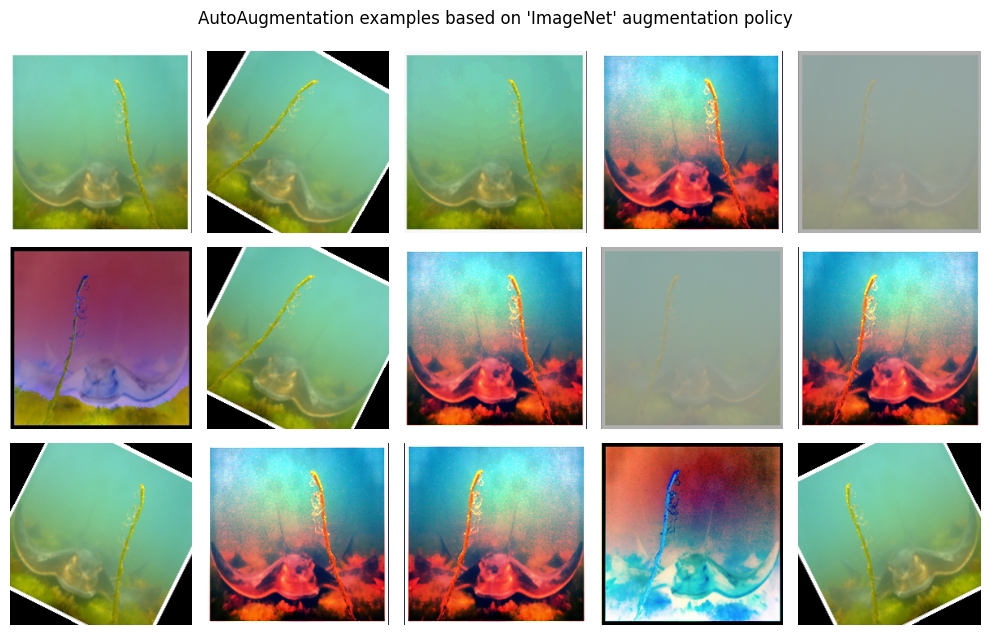

In [22]:
img = Image.open("imageneta.png").convert("RGB").resize((224,224))
augmenter = get_augmenter()

fig, axs = plt.subplots(3,5, figsize=(10,6.5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow((augmenter(img)))
    ax.axis("off")

plt.suptitle("AutoAugmentation examples based on 'ImageNet' augmentation policy")
plt.tight_layout()
plt.show()

### Load and testing Super Resolution model


In [24]:
# clone repo
if not os.path.exists("SwinIR"):
    !git clone https://github.com/JingyunLiang/SwinIR.git

# load pretrained model params
if not os.path.exists("experiments"):
    !wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models

Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 333 (delta 6), reused 5 (delta 2), pack-reused 320
Receiving objects: 100% (333/333), 29.84 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (119/119), done.
--2024-05-31 07:38:06--  https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/396770997/f3c0fbd1-d787-49f1-924a-8939e9a6707c?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20240531%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20240531T073806Z&X-Amz-Expires=300&X-Amz-Signature=529125dcbef724a940542e6bb37d207f50cbda39769159b18ef3

In [25]:
from SwinIR.models.network_swinir import SwinIR as net

def get_sr_model():
    """ Return SR model
    """
    # state dict specification
    param_key_g = 'params_ema'
    model = net(upscale=4, in_chans=3, img_size=64, window_size=8,
                img_range=1., depths=[6, 6, 6, 6, 6, 6],
                embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
                mlp_ratio=2, upsampler='nearest+conv', resi_connection='1conv')
    model = model.to(DEVICE)
    pretrained_model = torch.load("experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth")
    model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)
    return model


def sr_run(lr_image, model, sf, tile, overlap, verbose=True):
    """ Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
    Args:
        lr_image: (PIL image) low resolution image to be upscaled
        model: (torch.nn.Module) super resolution model
        sf: (int) scale factor, (default: 4)
        tile: (int) tile size while splitting the SR run (default: 32, 64)
        overlap: (int) pixel overlap
    Return:
        sr_image (torch.Tensor) dims: (1, c, h, w)
    """
    lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

    print(f"  LR image size: {lr_image.shape}", end=" ") if verbose else None

    model.eval()

    b, c, h, w = lr_image.size()

    fullImagePass = True if min(h, w) <= tile else False

    # test the image without tiling
    if fullImagePass:
        print(" - Full pass LR image...") if verbose else None
        with torch.no_grad():
            sr_image = model(lr_image.to(DEVICE))

    # unfold and process the image tile by tile
    else:
        if verbose:
            print(" - Unfolding LR image...")
        assert tile < min(h,w), "Tile must be less than imagesize (h,w) "
        stride = tile - overlap
        h_ids = [i for i in range(0, h - tile, stride)]
        w_ids = [j for j in range(0, w - tile, stride)]
        h_ids.append(h - tile)
        w_ids.append(w - tile)
        h_idx_list = list(range(0, h - tile, stride)) + [h - tile]
        w_idx_list = list(range(0, w - tile, stride)) + [w - tile]

        # Init output of zeros
        E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
        W = torch.zeros_like(E)

        # Unfold and perform sr over patches
        for h_id in h_ids:
            for w_id in w_ids:
                in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]

                with torch.no_grad():
                    out_patch = model(in_patch.to(DEVICE))

                out_patch = out_patch.to("cpu")
                out_patch_mask = torch.ones_like(out_patch)
                E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
        sr_image = E.div_(W)

    return sr_image

In [ ]:
# select image:
x = ttf.to_tensor(Image.open("frog.jpg").convert("RGB").resize((56,56))).unsqueeze(0)

x = x.to(DEVICE)
srmodel = get_sr_model()
#sr = sr_run(x, srmodel, sf=4, tile=32, overlap=4)

#print("input:  ",x.shape)
#print("output: ",sr.shape)

  LR image size: torch.Size([1, 3, 56, 56])  - Unfolding LR image...
input:   torch.Size([1, 3, 56, 56])
output:  torch.Size([1, 3, 224, 224])


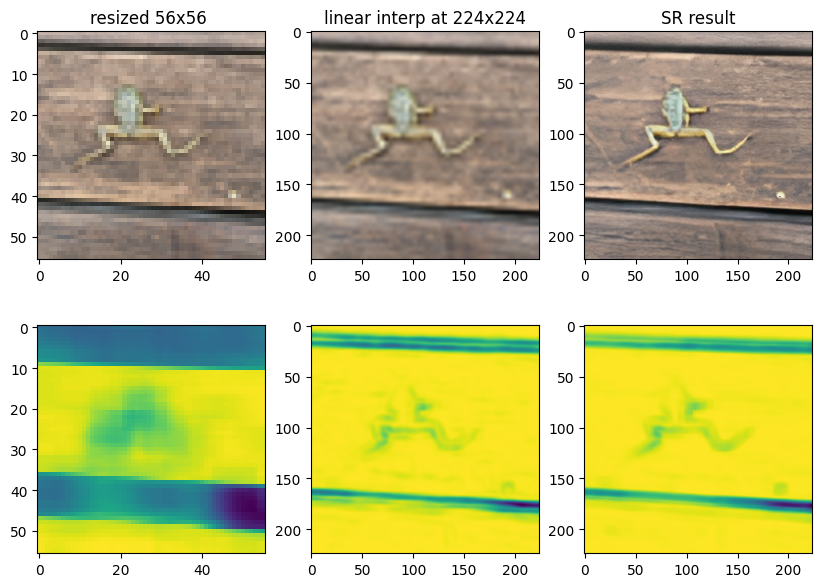

In [ ]:
kernel_size = 11

fig, ax = plt.subplots(2,3,figsize=(10,7))

ax[0,0].imshow(ttf.to_pil_image(x.squeeze(0)))
ax[0,0].set_title("resized 56x56 ")
ax[0,1].imshow(ttf.to_pil_image(x.squeeze(0)).resize((224,224)))
ax[0,1].set_title("linear interp at 224x224")
ax[0,2].imshow(ttf.to_pil_image(sr.squeeze(0)))
ax[0,2].set_title("SR result")

ax[1,0].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(x.squeeze(0)).convert("L")), kernel_size).squeeze(0))
ax[1,1].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(x.squeeze(0)).resize((224,224)).convert("L")), kernel_size).squeeze(0))
ax[1,2].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(sr.squeeze(0)).convert("L")), kernel_size).squeeze(0))

plt.show()

In [ ]:
# example usage (not useful anymore)
"""
!python SwinIR/main_test_swinir.py \
 --task real_sr \
 --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth \
 --folder_lq testdata \
 --scale 4 \
 --tile 800
 """

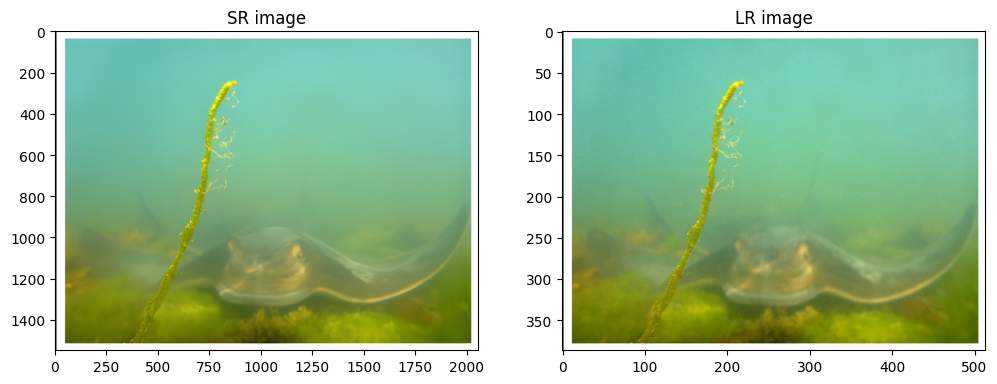

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,8))
axs[0].imshow(Image.open("results/swinir_real_sr_x4/imageneta_SwinIR.png"))
axs[0].set_title("SR image")
axs[1].imshow(Image.open("imageneta.png"))
axs[1].set_title("LR image")
plt.show()

### Testing the complete pipeline
Allowing to find the optimal bounding regions evolved to minimise a certain fitness function (according to either the _"model"_ or _"Entropy-only-"_ _"Frequecy-entropy-"_ map) that will be augmented in order to generate predictions and update model's parameters at test time.

In [182]:
import time
#-------------------------------------------------------------------------------
# *** Utility functions ***
#-------------------------------------------------------------------------------

def update_cache(cache, generation, value, cand_bb):
    """
    Update the optimization performance logs
    """
    cache["best_fit"][generation] = torch.min(value).item()
    cache["avg_fit"][generation] = torch.mean(value).item()
    cache["std_fit"][generation] = torch.std(value).item()
    cache["median_fit"][generation] = torch.median(value).item()
    cache["worst_fit"][generation] = torch.max(value).item()
    cache["cand_solutions"].append(cand_bb)
    cache["best_solutions"].append(cand_bb[torch.argmin(value).item()])
    return cache

def plot_performance(cache, Ntrials):
    """
    Plot fitness values along generations
    """
    plt.figure(figsize=(10,5))
    plt.plot(cache["best_fit"], color="green", label="best", linewidth=0.9, alpha=0.5, linestyle="dashed")
    plt.plot(cache["worst_fit"], color="red", label="worst", linewidth=0.9, alpha=0.5, linestyle="dashed")
    plt.plot(cache["median_fit"], color="black", label="median", linewidth=1.15, alpha=0.3)
    plt.plot(cache["avg_fit"], color="blue", label="avg", linewidth=1.15)
    plt.plot(cache["avg_fit"]+cache["std_fit"], color="blue", linewidth=0.3, alpha=0.3)
    plt.plot(cache["avg_fit"]-cache["std_fit"], color="blue", linewidth=0.3, alpha=0.3)
    plt.fill_between(range(0, Ntrials), cache["avg_fit"]+cache["std_fit"], cache["avg_fit"]-cache["std_fit"], alpha=0.1)
    plt.suptitle("CMA-ES performance")
    #plt.ylim((0,cache["worst_fit"].max().item()))
    plt.ylabel("Entropy")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def show_crop_results(cache, img, Ntrials, k):
    """
    Plot Cropping regions according to generations
    """
    gens = [1] + list(range(10,Ntrials+1,10))
    fig, axs = plt.subplots(3, 3, figsize=(12,8))
    fig.suptitle(f"Cropping regions over generations (k={k})", fontsize=14)
    im = np.asarray(img)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(im)
        for cbb in cache["cand_solutions"][gens[i]-1]:
            ax.add_patch(
                patches.Rectangle((cbb.xint, cbb.yint),
                                   cbb.wint, cbb.hint,
                                   linewidth=0.9,
                                   edgecolor='r',
                                   facecolor='none'))
        ax.axis("off")
        ax.set_title(f"Gen: {gens[i]}")
    plt.show()


#-------------------------------------------------------------------------------
# *** TTA related functions ***
#-------------------------------------------------------------------------------

def entropyModelFitness(model, batch):
    """
    Compute entropy of the cropped images organised in batch (n_item, c, w, h)
    """
    batch = batch.to(DEVICE)
    #with torch.no_grad():
    outputs = model(batch) # .squeeze(0)
    probs   = torch.softmax(outputs, -1)
    return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)


def entropyMapFitness(phenotype, alpha=0.001, epsilon=10**(-5)):
    """
    Compute the fitness of a cropped entropy / frequency-entropy map
    by estimating the mean entropy value over the area, penalized by the region size
    (the higher the better)
    """
    h,w = phenotype.shape[1:]
    return phenotype.mean() + alpha * (1 / ((h/224) * (w/224) + epsilon))


def resize_crop(img, x, y, w, h, target_dim):
    """ Return the unsqueeze cropped and resized image converted into tensor
    """
    if target_dim != None:
        res = ttf.to_tensor(ttf.crop(img, y, x, h, w).resize(target_dim)).unsqueeze(0)
    else:
        res = ttf.crop(img, y, x, h, w)
    return res


def get_fmap(baseimg, kernel_size, verbose=False):
    """ Return feature map by performing entropy pooling over the baseimage
    """
    t0 = time.time()
    try:
        # default torch module based implementation
        baseimg = baseimg.to(DEVICE)
        fmap = e_pooling(baseimg, kernel_size)
    except:
        # Just in case it will deal with some padded images
        fmap = entropy_pooling(baseimg, k=kernel_size, fun=entropy)
    t1 = time.time()
    print("E-pooling elapsed: ", round(t1-t0, 3)) if verbose else None
    return fmap.to("cpu")


def into_batch(img, phenotype, sample, mode):
    """ Return a batch of region proposal instances converted into tensor
    of size (nItems, nChannel, H, W)
    """
    if mode == "model":
        batch = torch.cat(phenotype, 0) # concat tensors whose dims are (1, c, h, w)

    elif mode in ("emap", "freqmap"):
        # resize at (image size) first and then concat
        cand_bb = [CropInstance(s[0], s[1], s[2], s[3], (224,224)) for s in sample]
        batch = [resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, (224,224)) for cbb in cand_bb]
        batch = torch.cat(batch, 0)

    return batch


def high_res(img, model, cand_bb, imgsize=(224,224), ratio=0.33, sf=4, tile=128,
             overlap=4):
    """
    Trying first a simple approach that convert into a super res image according
    to a given criterion (individually, not in batch while performing the full pass)
    Args:
        img:
        model:
        cand_bb:
        ratio: (float) (default = 0.33)
    Return:
        batch (list) of sr_images rescaled by a scale factor of 4 (default)
    """
    batch = []
    h, w = imgsize
    for cbb in cand_bb:

        # check for minimum area elegibility
        if cbb.wint * cbb.hint <= (h*w)*ratio:

            # region proposal extraction
            cropped = resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None) # PIL image

            # performing upscaling
            cropped = sr_run(cropped, model, sf=sf, tile=tile, overlap=overlap).squeeze(0)

            rescaled = ttf.to_tensor(ttf.to_pil_image(cropped).resize(imgsize)).unsqueeze(0)

        # rescaling to model size
        else:
            rescaled = resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, imgsize) # (1, )

        batch.append(rescaled) # list of tensor (1, c, h, w)
    return batch


def evolve(imgfilename, mode, Ntrials, popSize, kernel_size, seed, model, srmodel,
           verbose=True, display=False):
    """ Perform augmentation search in order to crop test image areas by
    minimising the objective function according to the 'mode' ('model', 'emap',
    'freqmap') approach.
    Args:
        image: (torch.Tensor) RGB (batch, 3, h, w) image resized at (224,224)
        mode: (str) optimization procedure allowed: ('model', 'emap', 'freqmap').
        Ntrials: (int) amount of evolutionary steps.
        popsize: (int) amount of instances to evolve.
        kernel_size: (int) entropy pooling size (for 'emap'/'freqmap' only).
        seed: (int) instance initialization seed.
        model: (torch.nn.Module) Image classifier model.
        srmodel: (torch.nn.Module) Super Resolution model.
        superRes: (bool) whether to use super resolution or not.
    Return:
        batch: torch.Tensor of dim (n_items, n_channel, h, w).
        solutions: (array) (solution_i, fitness_i) of the i-th evolved instance.
        cache: (dict) performance log.
    """
    # Initialize cache to store evolutionary performance
    cache = {"best_fit":np.zeros((Ntrials)),
             "avg_fit":np.zeros((Ntrials)),
             "std_fit":np.zeros((Ntrials)),
             "median_fit":np.zeros((Ntrials)),
             "worst_fit":np.zeros((Ntrials)),
             "cand_solutions":[],
             "best_solutions":[]}

    # Test image loading and feature map estimation
    # image will be given as a torch .tensor (not cliear it can pass a pil image)

    # to PIL image conversion
    orig = ttf.to_pil_image(image.squeeze(0))
    #orig = ttf.resize(Image.open(imgfilename).convert('RGB'), (224,224))  # PIL image

    if mode == "model":
        img = orig
    else:
        if mode == "emap":
            img     = ttf.to_tensor(ttf.resize(orig.convert('L'), (224, 224))) # tensor
            baseimg = img
        elif mode == "freqmap":
            img     = ttf.resize(orig.convert('L'), (224, 224)) # PIL image
            baseimg = freq_filter(img, h=224, w=224, s=224, freq="high")
        fmap = get_fmap(baseimg, kernel_size)  # torch.Tensor

    # CMA-ES Optimizer "ask-and-tell"-style instance initialization
    optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]), # distribution mean of (x,y,w,h)
                     sigma = 0.1,
                     bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                     population_size = popSize,
                     seed = seed,
                     lr_adapt=True)

    for generation in range(Ntrials):

        # draw the current generation sample
        sample = [optimizer4d.ask() for _ in range(optimizer4d.population_size)]

        # convert each candidate solution into a CropInstance bounding box
        cand_bb = [CropInstance(s[0], s[1], s[2], s[3], (224,224)) for s in sample]

        # Region proposal search by model prediction confidence
        if mode == "model":

            # Region proposal upscaling via SR model or default interpolation
            phenotype = high_res(img, srmodel, cand_bb) if bool(srmodel) \
                        else [resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, (224,224)) for cbb in cand_bb] # list of tensor (1, c, h, w) to be concatenate over axis 0
            batch     = into_batch(orig, phenotype, sample, mode)
            value     = entropyModelFitness(model, batch)

        # Region proposal search by low level visual information entropy minimization
        elif mode in ("emap", "freqmap"):
            phenotype = [resize_crop(fmap, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None) for cbb in cand_bb]
            value     = torch.tensor([entropyMapFitness(instance).item() for instance in phenotype])

        # Eval and draw new solutions
        solutions = [(sample[i], value[i].item()) for i in range(len(sample))]
        optimizer4d.tell(solutions)

        # Update cache and log
        cache = update_cache(cache, generation, value, cand_bb)
        if verbose:
            if (generation+1) % 1 == 0 or generation == 0:
                print(f"gen: {generation+1:3d}/{Ntrials}  -  "+
                      f"best: {cache['best_fit'][generation]:.6f}  -  "+
                      f"avg: {cache['avg_fit'][generation]:.6f}")

    # Checking for upscaling in entropy map conditions
    if mode in ("emap", "freqmap"):
        print("*** entropy map: final evo SR") if bool(srmodel) else None
        phenotype = high_res(orig, srmodel, cand_bb) if bool(srmodel) else phenotype
        batch = into_batch(orig, phenotype, sample, mode)

    # Displaying fitness optimization and crop results.
    if display:
        plot_performance(cache, Ntrials)
        if mode == "model":
            show_crop_results(cache, img, Ntrials, kernel_size)
        elif mode in ("emap", "freqmap"):
            show_crop_results(cache, fmap[0,:,:], Ntrials, kernel_size)

    return batch, cand_bb, solutions, cache


def augment(model, sample):
    """ Agument optimized bounding regions """
    # each image must be augmented individually otherwise the exactly same augmentation will be applied
    augmented = torch.cat([model(s).unsqueeze(0) for s in sample], 0)
    return augmented


# imgfilename must be replace with "orig" already loaded as PIL image resized and to RGB !!!
def single_test_time_adaptation(image, model, srmodel, evoparams, augmenter,
                                optimizer, loss_function, trainIter=1,
                                evoProposal=True, verbose=True):
    """ Perform prediction via TTA given a single test_image. Allows to perform
    region proposal by evolving image cropping instances by means of CMA-ES (set
    evoProposal)
    Args:
        image: (torch.Tensor) RGB (batch, 3, h, w) image resized at (224,224)
        model: (torch.nn.Module) visual encoder backbone
        srmodel: (torch.nn.Module) SR model
        evoparams: (dict) of region proposal search hyperparams
        augmenter: (torchvision.transforms.v2.Compose) transform block
        optimizer: (default torch.optim.Adam)
        loss_function: (defautl EntropyLoss)
        trainIter: (int) amount of self-supervised training steps (default: 1)
        evoProposal: (bool) True for evo-derived region proposal, False otherwise
        verbose: (bool) display progress
    Return:
        final batch of images, cumulative confidence and loss
    """
    cum_loss = torch.zeros((trainIter+1))
    cum_prob = torch.zeros((trainIter+1, evoparams["popSize"], NCLASSES))

    # In order to reset back model state after training/inference
    state_dict = copy.deepcopy(model.state_dict())
    optim_dict = copy.deepcopy(optimizer.state_dict())

    model.train()

    for epoch in range(0, trainIter):

        print(epoch)
        print(f"Now on epoch: {epoch+1}/{trainIter}")

        # collect a batch of region proposal evolved over generation and train
        #if epoch < trainIter:

        if evoProposal:
            batch, _, _, _ = evolve(image,
                                    mode = evoparams["mode"],
                                    Ntrials = evoparams["Ntrials"],
                                    popSize = evoparams["popSize"],
                                    kernel_size = evoparams["kernel_size"],
                                    seed = np.random.randint(0,10**5),
                                    model = model,
                                    srmodel = srmodel,
                                    verbose=True, display=False)
        else:
            # pay attention here to use a PIL image object from dataloader
            batch = ttf.to_tensor(imgfilename).repeat(evoparams["popSize"], 1, 1, 1)

        batch = augment(augmenter, batch) if not augmenter==None else batch
        batch = batch.to(DEVICE)
            #past_batch = copy.deepcopy(batch)

        # gather the past batch of region proposal and test
        #else:
        #    batch = past_batch.to(DEVICE)
        #    break

        # Forward pass
        outputs = model(batch).to(DEVICE)
        probs = torch.softmax(outputs, -1)
        avg_probs = probs.mean(axis=0)

        # Loss computation
        loss = loss_function(avg_probs)

        # Backward pass
        loss.backward()

        # Parameters update
        optimizer.step()

        # Gradients reset
        optimizer.zero_grad()

        # Saving logs
        cum_prob[epoch, :, :] = probs
        cum_loss[epoch] = loss.item()
        print("Current loss: ", loss.item(), end="\n"+str("-"*70)+"\n") if verbose else None

    # Inference
    # "Episodic" version (updating within each single test datapoint)
    model.eval()

    # Inference over a newly generate batch of region proposal
    with torch.no_grad():
        outputs = model(batch).to(DEVICE)
        probs = torch.softmax(outputs, -1)
        avg_probs = probs.mean(axis=0)

        inference_loss  = loss_function(avg_probs)
        cum_prob[trainIter, :, :] = probs
        cum_loss[trainIter] = inference_loss.item()

    # reset current model/optimizer params
    model.load_state_dict(state_dict)
    optimizer.load_state_dict(optim_dict)

    return batch, cum_prob, cum_loss


def get_pred_label(cum_prob, how="avg", labels=LABELS):
    """ Return the confidence of the predicted label at inference time according
    to either ('avg' or 'max') conditions
    """
    if how == "max":
        raise NotImplementedError
        #confidence, class_n = cum_prob[-1,:,:].max().item(), cum_prob[-1,:,:].argmax().item()
    elif how == "avg":
        confidence = cum_prob[-1,:,:].mean(0).max().item()
        class_n = cum_prob[-1,:,:].mean(0).argmax().item()
    return labels[class_n], class_n, confidence


def main(dataloader, model, evoparams, withSRmodel=True, withAutoAugment=True,
         trainIter=1, evoProposal=True, verbose=True):
    """ Collapse everything in order to perform TTA on a single test point """

    # init accuracy vars
    corr_pred, n_sample = 0.0, 0.0

    # plotting grid
    #nrows, ncols = (2,4); assert nrows*ncols == evoparams["popSize"], "Gridsize!"

    srmodel       = get_sr_model() if withSRmodel else None
    augmenter     = get_augmenter() if withAutoAugment else None
    optimizer     = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    loss_function = EntropyLoss()

    #train_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=False, num_workers=4)
    for idx, (image, true_label) in enumerate(dataloader):

        # image will be given as a tensor in original img size
        image = image.to(DEVICE)

        evobatch, cum_prob, cum_loss = single_test_time_adaptation(
            image,
            model = model,
            srmodel = srmodel,
            evoparams = evoparams,
            augmenter = augmenter,
            optimizer = optimizer,
            loss_function = loss_function,
            evoProposal = evoProposal,
            trainIter = trainIter)

        pred_label, pred_class_n, confidence = get_pred_label(cum_prob)

        # label conversion to match those from the testdataset
        pred_label = COMMON[pred_label]

        # still some name inconsistency are present (better to work with class numbers)
        corr_pred = corr_pred + 1 if true_label == pred_label else corr_pred + 0
        n_sample += 1

    accuracy_top1 = corr_pred / n_sample

    return accuracy_top1

### Testing the learning procedure

In [186]:
# loading the input image as a PIL image
image = ttf.to_tensor(Image.open("imageneta.png").convert("RGB").resize((224,224)))
label = "stingray"

# declare hyperparams
backbonename    = ["vit"] # ["ResNet50", "RVT"]
modes           = ["model", "emap", "freqmap"]
popSizes        = [4, 8] # or [8, 16]
Ntrials         = [5]
kernel_sizes    = [3, 11, 33] # or [3, 11] / [5, 11]
sr_conditions   = [True]
augm_conditions = [True, False]

# draw combinations
combinations = list(itertools.product(modes, popSizes, Ntrials, kernel_sizes, sr_conditions, augm_conditions))

mode, popSize, Ntrial, kernel_size, enableSR, enableAugm = combinations[0]

evoparams = {
    "mode":"freqmap", "popSize":8, "Ntrials":5, "kernel_size":11,
}

# apparently you must declare all models and params outside the function
model = backbone_loading(backbonename[0])
srmodel = get_sr_model()
augmenter = get_augmenter()
loss_function = EntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))


batch, cum_prob, cum_loss = single_test_time_adaptation(
                                image, model, srmodel,
                                evoparams, augmenter,
                                optimizer, loss_function, trainIter=1,
                                evoProposal=True, verbose=True
                                )
print(cum_loss)

0
Now on epoch: 1/1
gen:   1/5  -  best: 4.582975  -  avg: 4.601465
gen:   2/5  -  best: 4.558671  -  avg: 4.582778
gen:   3/5  -  best: 4.532538  -  avg: 4.589931
gen:   4/5  -  best: 4.554743  -  avg: 4.572369
gen:   5/5  -  best: 4.553534  -  avg: 4.569070
*** entropy map: final evo SR
  LR image size: torch.Size([1, 3, 37, 141])  - Full pass LR image...
  LR image size: torch.Size([1, 3, 37, 120])  - Full pass LR image...
  LR image size: torch.Size([1, 3, 85, 96])  - Full pass LR image...
  LR image size: torch.Size([1, 3, 37, 103])  - Full pass LR image...
  LR image size: torch.Size([1, 3, 37, 113])  - Full pass LR image...
  LR image size: torch.Size([1, 3, 121, 37])  - Full pass LR image...
  LR image size: torch.Size([1, 3, 37, 74])  - Full pass LR image...
  LR image size: torch.Size([1, 3, 84, 98])  - Full pass LR image...
Current loss:  4.599996566772461
----------------------------------------------------------------------
tensor([4.6000e+00, 1.9553e-07])


### Re-implementation
Test it first

In [60]:
import os
import csv
import time
import itertools

class EvoTTA(object):
    """ Structure that will manage the evolutionary search, augmentation
    and inference procedure by performing an "episodic" learning stage at
    inference time.
    """
    def __init__(self, image, label, model, srmodel, hparams,
        augmenter, loss_function, optimizer, imgsize=(224,224),
        sr_ratio=0.33, n_classes=1000):

        self.image = image
        self.label = label
        self.model = model
        self.srmodel = srmodel

        self.mode        = hparams["mode"]
        self.Ntrials     = hparams["Ntrials"]
        self.popSize     = hparams["popSize"]
        self.kernel_size = hparams["kernel_size"]
        self.enableSR    = hparams["enableSR"]
        self.enableAugm  = hparams["enableAugm"]

        self.augmenter     = augmenter
        self.loss_function = loss_function
        self.optimizer     = optimizer
        self.imgsize       = imgsize
        self.sr_ratio      = sr_ratio

        self.h_sample, self.h_cand_bb, self.h_phenotype, self.h_solutions = [],[],[],[]

        self.cache = dict()
        self.n_classes = n_classes


    #-------------------------------------------------------------------------------
    # *** General class utility functions
    #-------------------------------------------------------------------------------

    def init_cache(self):
        """ Cache initialzion storing evo-derived region proposal performance
        """
        if self.cache == dict():
            self.cache = {"best_fit":np.zeros((self.Ntrials)),
                         "avg_fit":np.zeros((self.Ntrials)),
                         "std_fit":np.zeros((self.Ntrials)),
                         "median_fit":np.zeros((self.Ntrials)),
                         "worst_fit":np.zeros((self.Ntrials)),
                         "cand_solutions":[],
                         "best_solutions":[],
                         }

    def update_cache(self, generation, value, phenotype):
        """ Update the optimization performance logs
        """
        self.cache["best_fit"][generation] = torch.min(value).item()
        self.cache["avg_fit"][generation] = torch.mean(value).item()
        self.cache["std_fit"][generation] = torch.std(value).item()
        self.cache["median_fit"][generation] = torch.median(value).item()
        self.cache["worst_fit"][generation] = torch.max(value).item()
        self.cache["cand_solutions"].append(phenotype)
        self.cache["best_solutions"].append(phenotype[torch.argmin(value).item()])

    def plot_performance(self):
        """ Plot fitness values along generations
        """
        plt.figure(figsize=(10,5))
        plt.plot(self.cache["best_fit"],\
            color="green", label="best", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["worst_fit"],\
            color="red", label="worst", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["median_fit"],\
            color="black", label="median", linewidth=1.15, alpha=0.3)
        plt.plot(self.cache["avg_fit"],\
            color="blue", label="avg", linewidth=1.15)
        plt.plot(self.cache["avg_fit"]+self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.plot(self.cache["avg_fit"]-self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.fill_between(range(0, self.Ntrials),\
            self.cache["avg_fit"]+self.cache["std_fit"],\
            self.cache["avg_fit"]-self.cache["std_fit"],\
            alpha=0.1)
        plt.suptitle("CMA-ES performance")
        plt.ylabel("Region proposal avg entropy")
        plt.xlabel("Generation")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def show_crop_results(self):
        """ Plot Cropping regions according to generations
        """
        gens = [1] + list(range(10, self.Ntrials+1, 10))
        fig, axs = plt.subplots(3, 3, figsize=(12,8))
        fig.suptitle(f"Cropping regions over generations (k={self.kernel_size})", fontsize=14)

        for i, ax in enumerate(axs.flatten()):
            ax.imshow(np.asarray(self.image))
            for cbb in self.cache["cand_solutions"][gens[i]-1]:
                ax.add_patch(
                    patches.Rectangle((cbb.xint, cbb.yint),
                                       cbb.wint, cbb.hint,
                                       linewidth=0.9,
                                       edgecolor='r',
                                       facecolor='none'))
            ax.axis("off")
            ax.set_title(f"Gen: {gens[i]}")
        plt.show()

    #-------------------------------------------------------------------------------
    # *** TTA utility functions:
    #-------------------------------------------------------------------------------

    @staticmethod
    def entropyModelFitness(model, batch):
        """ Compute entropy of the cropped images organised in batch (n_item, c, w, h)
        """
        batch = batch.to(DEVICE)

        model.eval()
        with torch.no_grad():
            outputs = model(batch)
            probs   = torch.softmax(outputs, -1)
            return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)

    @staticmethod
    def entropyMapFitness(phenotype, imgsize, alpha=0.001, epsilon=10**(-5)):
        """ Compute the fitness of a cropped entropy / frequency-entropy map
        by estimating the mean entropy value over the area, penalized by the
        region size (the higher the better).
        """
        h, w = phenotype.shape[1:]
        h_ref, w_ref = imgsize
        return phenotype.mean() + alpha * (1 / ((h/h_ref) * (w/w_ref) + epsilon))

    @staticmethod
    def get_fmap(img, kernel_size, verbose=True):
        """ Feature map estimation by performing entropy pooling over
        the baseimage.
        """
        t0 = time.time()

        try:
            img = img.to(DEVICE)
            fmap = e_pooling(img, kernel_size)
        except:
            fmap = entropy_pooling(img, kernel_size, fun=entropy)

        t1 = time.time()
        print("E-pooling elapsed: ", round(t1-t0, 3)) if verbose else None
        return fmap.to("cpu")

    @staticmethod
    def resize_crop(img, x, y, w, h, target_dim):
        """ Return the unsqueeze cropped and resized image converted into tensor
        """
        if target_dim != None:
            resized = ttf.to_tensor(ttf.crop(img, y, x, h, w)\
                .resize(target_dim))\
                .unsqueeze(0)
        else:
            resized = ttf.crop(img, y, x, h, w)
        return resized

    @staticmethod
    def into_batch(img, phenotype, sample, mode, imgsize):
        """ Return a batch of region proposal instances converted into tensor
        of size (nItems, nChannel, H, W)
         """
        if mode == "model":
            batch = torch.cat(phenotype, 0) # concat tensors whose dims are (1, c, h, w)

        elif mode in ("emap", "freqmap"):
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], imgsize)\
                        for s in sample]
            batch   = [EvoTTA.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, imgsize)\
                        for cbb in cand_bb]
            batch   = torch.cat(batch, 0)

        return batch

    @staticmethod
    def augment(augmenter, sample):
        """ Perform data augmentation via augmenter obj
        """
        return torch.cat([augmenter(s).unsqueeze(0) for s in sample], 0)

    @staticmethod
    def get_pred_label(cum_prob, nclass2label, how="avg"):
        """ Return the confidence of the predicted label at inference time according
        to either ('avg' or 'max') conditions
        Args:
            cum_prob: (torch.Tensor) of prediction confidence (n_epoch, n_istance, n_classes)
            nclass2label: (dict) object that maps class number to original Imagenet_1k class names
            how: (str) way to compute prediction ('max', 'avg')
        Return:
            class label, class number, confidence level
        """
        assert how in ("max", "avg"), "Options allowed: ('max', 'how')"
        if how == "max":
            raise NotImplementedError
            #confidence, class_n = cum_prob[-1,:,:].max().item(), cum_prob[-1,:,:].argmax().item()
        elif how == "avg":
            confidence = cum_prob[-1,:,:].mean(0).max().item()
            nclass = cum_prob[-1,:,:].mean(0).argmax().item()
            label = nclass2label[nclass]
        return label, nclass, confidence

    @staticmethod
    def sr_run(lr_image, srmodel, sf, tile, overlap, verbose=True):
        """ Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
        Args:
            lr_image: (PIL image) low resolution image to be upscaled
            srmodel: (torch.nn.Module) superresolution model
            sf: (int) Scaling Factor, (default: 4)
            tile: (int) tile size while splitting the SR run (default: 128)
            overlap: (int) pixel overlap
        Return:
            sr_image (torch.Tensor) dims: (1, c, h, w)
        """
        lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

        print(f"  LR image size: {lr_image.shape}", end=" ") if verbose else None

        srmodel.eval()

        b, c, h, w = lr_image.size()

        # (full image pass condition): test the image without unfolding in tiles
        if min(h, w) <= tile:
            print(" - Full pass LR image...") if verbose else None
            with torch.no_grad():
                lr_image = lr_image.to(DEVICE)
                sr_image = srmodel(lr_image)

        # unfold and process test image by tiles
        else:
            assert tile < min(h,w), "Tile must be less than imagesize (h,w)."
            print(" - Unfolding LR image...") if verbose else None
            stride = tile - overlap
            h_ids = [i for i in range(0, h - tile, stride)] + [h - tile]
            w_ids = [j for j in range(0, w - tile, stride)] + [w - tile]

            # Init output of zeros
            E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
            W = torch.zeros_like(E)

            # Unfold and perform sr over patches
            for h_id in h_ids:
                for w_id in w_ids:
                    in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]
                    in_patch = in_patch.to(DEVICE)
                    with torch.no_grad():
                        out_patch = srmodel(in_patch)
                    out_patch = out_patch.to("cpu")
                    out_patch_mask = torch.ones_like(out_patch)
                    E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                    W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
            sr_image = E.div_(W)

        return sr_image

    #-------------------------------------------------------------------------------
    # *** TTA main functions:
    #-------------------------------------------------------------------------------

    def high_res(self, img, cand_bb, sf=4, tile=128, overlap=4):
        """ Trying first a simple approach that convert into a super res image according
        to a given criterion (individually, not in batch while performing the full pass)
        Args:
            img:
            cand_bb:
            ratio: (float) (default = 0.33)
        Return:
            batch (list) of sr_images rescaled by a scale factor of 4 (default)
        """
        batch = []
        h, w = self.imgsize

        for cbb in cand_bb:

            # check for minimum area elegibility
            if cbb.wint * cbb.hint <= (w*h) * self.sr_ratio:

                # region proposal extraction
                cropped = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)

                # performing upscaling
                cropped = self.sr_run(cropped, self.srmodel, sf, tile, overlap).squeeze(0)
                rescaled = ttf.to_tensor(ttf.to_pil_image(cropped).resize(self.imgsize)).unsqueeze(0)

            # rescaling to model size if region proposal area is > ratio
            else:
                rescaled = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)

            batch.append(rescaled) # list of tensor (1, c, h, w)
        return batch


    def evolve(self, verbose=True, display=False):
        """ Perform augmentation search in order to crop test image areas by
        minimising the objective function according to the 'mode' ('model', 'emap',
        'freqmap') approach.

        Return:
            batch: torch.Tensor of dim (n_items, n_channel, h, w).
            solutions: (array) (solution_i, fitness_i) of the i-th evolved instance.
            cache: (dict) performance log.
        """
        self.init_cache()

        # preprocess test image and extract feature map if mode in ("emap", "freqmap")
        orig = ttf.to_pil_image(self.image.squeeze(0))

        if self.mode == "model":
            img = orig

        elif self.mode == "emap":
            img = ttf.to_tensor(ttf.resize(orig.convert("L"), self.imgsize))
            fmap = self.get_fmap(img=img,
                                 kernel_size=self.kernel_size)

        elif self.mode == "freqmap":
            img = ttf.resize(orig.convert("L"), self.imgsize)
            fmap = self.get_fmap(img=freq_filter(img, self.imgsize[0], self.imgsize[1], self.imgsize[1], freq="high"),
                                 kernel_size=self.kernel_size)

        # CMA-ES Optimizer "ask-and-tell"-style instance initialization
        # search space in 4 dimensions (bounding box x0, y0, h, w parameters)
        optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]),
                          sigma = 0.1,
                          bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                          population_size = self.popSize,
                          seed = np.random.randint(0, 10**5),
                          lr_adapt=True)

        # evolving over generations
        for generation in range(self.Ntrials):

            # draw the current generation sample
            sample =  [optimizer4d.ask() for _ in range(optimizer4d.population_size)]

            # convert each candidate solution into a CropInstance bounding box
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], self.imgsize) for s in sample]

            # region proposal search by model prediction confidence
            if self.mode == "model":
                phenotype = self.high_res(img, cand_bb) if self.enableSR \
                            else [self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)\
                                  for cbb in cand_bb] # list of tensor (1, c, h, w) to be concatenate over axis 0
                batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)
                value = self.entropyModelFitness(self.model, batch)

            # region proposal search by low level visual information entropy minimization
            elif self.mode in ("emap", "freqmap"):
                phenotype = [self.resize_crop(fmap, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)\
                             for cbb in cand_bb]
                value = torch.tensor([self.entropyMapFitness(instance, self.imgsize).item()\
                             for instance in phenotype])

            # Eval and draw new solutions
            solutions = [(sample[i], value[i].item()) for i in range(len(sample))]
            optimizer4d.tell(solutions)

            # Update cache
            self.update_cache(generation, value, phenotype)

            if verbose:
                if (generation+1) % 1 == 0 or generation == 0:
                    print(f"gen: {generation+1:3d}/{self.Ntrials}  -  "+
                          f"best: {self.cache['best_fit'][generation]:.6f}  -  "+
                          f"avg: {self.cache['avg_fit'][generation]:.6f}")

        # Checking for upscaling in entropy map conditions
        if self.mode in ("emap", "freqmap"):
            print("*** entropy map: final evo SR") if self.enableSR else None
            phenotype = self.high_res(orig, cand_bb) if self.enableSR else phenotype
            batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)

        # Displaying fitness optimization and crop results
        if display:
            self.plot_performance()
            if self.mode == "model":
                self.show_crop_results(cache, self.image, self.Ntrials, self.kernel_size)
            elif self.mode in ("emap", "freqmap"):
                self.show_crop_results(cache, fmap[0,:,:], self.Ntrials, self.kernel_size)

        return batch, cand_bb, solutions


    def single_test_time_adaptation(self, trainIter=1, evoProposal=True, verbose=True):
        """ Perform prediction via TTA given a single test_image. Allows to perform
        region proposal by evolving image cropping instances by means of CMA-ES (set
        evoProposal)
        Args:
            trainIter: (int) amount of self-supervised training steps (default: 1)
            evoProposal: (bool) True for evo-derived region proposal, False otherwise
            verbose: (bool) display progress
        Return:
            final batch of images, cumulative confidence and loss
        """
        cum_loss = torch.zeros((trainIter+1))
        cum_prob = torch.zeros((trainIter+1, self.popSize, self.n_classes))

        # In order to reset back model state after training/inference
        state_dict = copy.deepcopy(self.model.state_dict())
        optim_dict = copy.deepcopy(self.optimizer.state_dict())

        # allow model to be trained
        self.model.train()

        for epoch in range(0, trainIter+1):

            print(f"Now on epoch: {epoch+1}" if epoch != trainIter else "Inference:")

            # collect a batch of region proposal evolved over generation and train
            if epoch < trainIter:

                if evoProposal:
                    batch, _, _, = self.evolve()
                else:
                    batch = self.image.repeat(self.popSize, 1, 1, 1)

                batch = self.augment(self.augmenter, batch) if self.enableAugm else batch
                batch = batch.to(DEVICE)

                # save each past current batch to be processed in a temporary var
                past_batch = batch

            # gather the past batch of region proposal for final inference
            else:
                batch = past_batch
                break

            # Forward pass
            outputs = self.model(batch).to(DEVICE)
            probs = torch.softmax(outputs, -1)
            avg_probs = probs.mean(axis=0)

            # Loss computation
            loss = self.loss_function(avg_probs)

            # Backward pass
            loss.backward()

            # Parameters update
            self.optimizer.step()

            # Gradients reset
            self.optimizer.zero_grad()

            # Saving logs
            cum_prob[epoch, :, :] = probs
            cum_loss[epoch] = loss.item()
            print("Current loss: ", loss.item(), end="\n"+str("-"*70)+"\n") if verbose else None

        # "Episodic" version (updating within each single test datapoint)
        self.model.eval()

        # Inference over a newly generate batch of region proposal
        with torch.no_grad():
            outputs = self.model(batch.to(DEVICE))
            inference_probs = torch.softmax(outputs, -1)
            inference_loss  = self.loss_function(probs)
            cum_prob[trainIter, :, :] = inference_probs
            cum_loss[trainIter] = inference_loss

        # reset current model/optimizer params
        self.model.load_state_dict(state_dict)
        self.optimizer.load_state_dict(optim_dict)

        return batch, cum_prob, cum_loss


# The following class is supposed to manage the test data evaluation according to
# the proposed Evo TTA approach.

class EvalEvoTTA(object):

    def __init__(self, backbonename, combinations, dataloader,
        nclass2label, label2label, outfile):
        self.backbonename = backbonename
        self.model = backbone_loading(backbonename)
        self.srmodel = get_sr_model()
        self.augmenter = get_augmenter()
        self.loss_function = EntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
        self.combinations = combinations
        self.dataloader = dataloader
        self.outfile = outfile

        # maps
        self.nclass2label = nclass2label
        self.label2label  = label2label


    @staticmethod
    def store_results(file, header, data):
        """ Save results in csv
        """
        if not os.path.exists(file):
            os.system(f"echo {header} > {file}")
        with open(file, "a", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(data)


    def run_single_hset(self, combination, trainIter=1):
        """ Perform TTA evaluation over test data given a set of hyperparams
        """
        mode, Ntrial, popSize, kernel_size, enableSR, enableAugm = combination

        # build evoparams
        hparams = {
            "mode":mode, "Ntrials":Ntrial, "popSize":popSize, "kernel_size":kernel_size,
            "enableSR":enableSR, "enableAugm":enableAugm,
        }

        t0 = time.time()

        for idx, (image, true_label) in enumerate(self.dataloader):

            evoTTA = EvoTTA(
                image = image,
                label = true_label,
                model = self.model,
                srmodel = self.srmodel,
                hparams = hparams,
                augmenter = self.augmenter,
                loss_function = self.loss_function,
                optimizer = self.optimizer,
                imgsze = (224,224),
            )

            batch, cum_prob, cum_loss = evoTTA.single_test_time_adaptation(trainIter, evoProposal=True)

            pred_label, pred_class_n, conf = evoTTA.get_pred_label(cum_prob, self.nclass2label, "avg")

            # label conversion to match those from the testdataset
            pred_label = self.label2label[pred_label]

            corr_pred = corr_pred + 1 if true_label == pred_label else corr_pred + 0
            n_sample += 1

        t1 = time.time()
        elapsed = round(t1-t0, 4)

        accuracy_top1 = corr_pred / n_sample

        # storing result in a csv
        header = "'backbone,mode,Ntrials,popSize,kernel_size,enableSR,enableAugm,trainIter,errorRate,time'"
        data   = [backbonename] + [value for k in hparams] + [trainIter] + [1-accuracy_top1] + [elapsed]
        self.store_results(self.outfile, header, data)

        return 1 - accuracy_top1


    def run_all_hset(self):
        """ Run all """
        for combination in self.combinations:
            self.run_single_hset(combination)


### Running the Re-implementation

In [98]:
#outfile = "evoTTA_performance.csv"

# loading the input image as a PIL image
image = ttf.to_tensor(Image.open("imageneta.png").convert("RGB").resize((224,224)))
label = "stingray"

# declare hyperparams
backbonename    = ["vit"] # ["ResNet50", "RVT"]
modes           = ["model", "emap", "freqmap"]
popSizes        = [4, 8] # or [8, 16]
Ntrials         = [5]
kernel_sizes    = [3, 11, 33] # or [3, 11] / [5, 11]
sr_conditions   = [True]
augm_conditions = [True, False]

# draw combinations
combinations = list(itertools.product(modes, popSizes, Ntrials, kernel_sizes, sr_conditions, augm_conditions))

mode, popSize, Ntrial, kernel_size, enableSR, enableAugm = combinations[0]

hparams = {
    "mode":"emap", "popSize":popSize, "Ntrials":Ntrial, "kernel_size":kernel_size,
    "enableSR":enableSR, "enableAugm":enableAugm,
}

# apparently you must declare all models and params outside the function
model = backbone_loading(backbonename[0])
srmodel = get_sr_model()
augmenter = get_augmenter()
loss_function = EntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

print(hparams)

evotta = EvoTTA(
        image=image,
        label=label,
        model=model,
        srmodel=srmodel,
        hparams=hparams,
        augmenter=augmenter,
        loss_function=loss_function,
        optimizer=optimizer,
        imgsize=(224,224),
        sr_ratio=0.33, n_classes=1000,
)

re = evotta.single_test_time_adaptation(trainIter=3, evoProposal=True)


{'mode': 'emap', 'popSize': 4, 'Ntrials': 5, 'kernel_size': 3, 'enableSR': True, 'enableAugm': True}
Now on epoch: 1
E-pooling elapsed:  0.001
gen:   1/5  -  best: 2.197584  -  avg: 2.199765
gen:   2/5  -  best: 2.198223  -  avg: 2.199470
gen:   3/5  -  best: 2.197555  -  avg: 2.199092
gen:   4/5  -  best: 2.197715  -  avg: 2.198602
gen:   5/5  -  best: 2.197429  -  avg: 2.197835
*** entropy map: final evo SR


TypeError: 'NoneType' object is not callable

In [97]:
re[-1]


tensor([2.8178e+00, 8.3139e-01, 1.3008e-06, 5.2030e-06])

AWS bucket initialisation.


In [ ]:
class S3ImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, folder_to_labels, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform
        self.folder_to_labels = folder_to_labels

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"])
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm",
                ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        try:
            foldername, key = self.instances[idx]

            # folder name to label conversion
            label = self.folder_to_labels[foldername]

            # Download image from S3
            response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=key)
            img_bytes = response["Body"]._raw_stream.data

            img_bytes = BytesIO()
            response = self.s3_client.download_fileobj(Bucket=self.s3_bucket,
                                                       Key=key, Fileobj=img_bytes)
            #img_bytes = response["Body"]._raw_stream.data

            # Open image with PIL
            img = torchvision.transforms.functional.to_tensor(Image.open(img_bytes)\
                                                              .convert("RGB")\
                                                              .resize((224,224)))
            # Apply transformations if any
            if self.transform is not None:
                img = self.transform(img)

        except Exception as e:
            raise RuntimeError(f"Error loading image at index {idx}: {str(e)}")

        return img, label


def get_dataloader(batch_size, img_root, transform):
    """ Return the imagenet-a dataloader instance """
    dataset = S3ImageFolder(root=img_root,
                            folder_to_labels=FOLDERS,
                            transform=transform)
    return torch.utils.data.DataLoader(dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)


# example usage
img_root = "imagenet-a"
dataloader = get_dataloader(1, img_root, None)

for i, (image_tensor, true_label) in enumerate(dataloader):
    break


Inspecting region proposal given some hyperparams

In [ ]:
#-------------------------------------------------------------------------------
filename = "turtle2.jpg"

# defining evo params
evoparams = dict()
evoparams["mode"]        = "model" # available ("model", "emap", "freqmap")
evoparams["Ntrials"]     = 10  # try to put here a way to modify parameters like in lab{}
evoparams["popSize"]     = 8  # amount of instances to be evolved at each gen
evoparams["kernel_size"] = 11  # entropy pooling size
#evoparams["seed"]        = np.random.randint(0,1000)

# augmentation
withSRmodel     = True
withAutoAugment = True
#-------------------------------------------------------------------------------

# plotting grid
nrows, ncols = (2,4); assert nrows*ncols == evoparams["popSize"], "Gridsize!"

# loading model
model = backbone_loading("vit")
srmodel = get_sr_model() if withSRmodel else None

# init augmenter/opt/loss
augmenter = get_augmenter() if withAutoAugment else None
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_function = EntropyLoss()

predss = []
# run TTA with evo region proposal
for _ in range(10):
    batch, cum_prob, cum_loss = single_test_time_adaptation(
            filename,
            model,
            srmodel,
            evoparams,
            augmenter,
            optimizer,
            loss_function,
            trainIter=1
    )
    preds = get_pred_label(cum_prob)
    print("\nAvg class prediction:\n", preds)
    predss.append(preds)

# displaying results
fig, axs = plt.subplots(nrows, ncols, figsize = (8,5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(ttf.to_pil_image(batch[i,:,:]))
    ax.axis("off")
pclass = f"Predicted class: {preds[0]}"
plt.suptitle(f"{pclass}\nInference region proposal: (mode='{evoparams['mode']}', popSize={evoparams['popSize']}, gen={evoparams['Ntrials']})" if evoparams['mode']=="model"
             else f"{pclass}\nInference region proposal: (mode='{evoparams['mode']}', popSize={evoparams['popSize']}, gen={evoparams['Ntrials']}, k={evoparams['kernel_size']})")
plt.tight_layout()
plt.show()

Testing both approaches (**model guided** crop search and **entropy map minimisation**)

In [ ]:
filename = "hawk.jpg"
mode = "model" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 11

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

In [ ]:
filename = "hawk.jpg"
mode = "emap" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 11

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

In [ ]:
filename = "hawk.jpg"
mode = "freqmap" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 0
kernel_size = 33

cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

In [ ]:
filename = "alligator.jpg"
mode = "freqmap" # alternatively "emap"

Ntrials = 80 # minimum amount to have everything working properly
popSize = 16
seed    = 8765
kernel_size = 3


cache = main(filename, mode, Ntrials, popSize, kernel_size, seed)

Displaying where the cropping regions coordinates had been converged according to a given `generation`.


Some notes:
apparently the mean initialisation seems not to influence the final convergence given sufficient instances to explore the space for a reasonable amount of generations. Some parameters are still needed to be tuned. The entropy minimum reached by the search algorithm is not corresponding to the perfectly cropped image subject. We may hope to rely on few optimisation evolutionary runs in order to get some original test image cropped areas to be used as prediction.
We can also try to classify each test image according to the resulting candidates over $N$ generations
